## Purpose: 
### 1. Which API has better overall coverage: Yelp or Foursquare?
### 2. Which 4 major cities in BC have on average the best rated restaurants and what are the top restaruants?
### 3. Of the top 100+ most populated US cities, what are the Top 5 cities that on average have the best rated restaurants?
### 4. Can I build a machine learning model to predict a sentiment/rating of a particular resturant?

In [1]:
import pandas as pd
import requests as re
import numpy as np
from pprint import pprint
import json
import time
import os
import matplotlib.pyplot as plt
from scipy import stats

import sqlite3 as sqlite
from sqlalchemy import create_engine

%matplotlib inline

In [5]:
yelp_client = os.environ.get('YELP_CLIENT')
yelp_api = os.environ.get('YELP_SECRET')

foursqure_client = os.environ.get('FOURSQUARE_CLIENT')
foursquare_secret = os.environ.get('FOURSQUARE_SECRET')

In [3]:
# This function takes in a string parameter called 'cityname', 
# and an api parameter thats defaulted to yelp, but can be changed to foursquare
# returns a list of dictionaries where each dictionary is an individual restaruant within that city.

def get_restaurant_results(radius=2000, limit=50, api='yelp', cityname=None, lat=None, lon=None):
    time.sleep(2)
    if api=='yelp':
        yelp_url = 'https://api.yelp.com/v3/businesses/search'
        headers = {'Authorization':'Bearer %s' % yelp_api}

        params = {'term': 'restaurants', 
                  'location': cityname,
                  'latitude':lat,
                  'longitude': lon,
                  'radius': radius,
                  'categories': 'restaurants',
                  'limit': limit}
        try:
            yelp_data = re.get(yelp_url, params=params, headers=headers)
            yelp_data = yelp_data.json()

            return yelp_data['businesses']
        except:
            print('Something went wrong!')
    
    elif api == 'foursquare':
        foursquare_url = 'https://api.foursquare.com/v2/venues/search'

        foursquare_params = dict(
        client_id=foursqure_client,
        client_secret=foursquare_secret,
        v='20180323',
        near=cityname,
        query='restaurant',
        radius=radius,
        limit=limit
        )
        
        try:
            resp = re.get(url=foursquare_url, params=foursquare_params)
            data_foursquare = json.loads(resp.text)
            return data_foursquare['response']['venues']
        except:
            print('Something went wrong!')

In [1]:
# # Returned from get_restaurant_results() is a list of dictionaries where each dictionary a restaurant

# get_restaurant_results(cityname='Vancouver, BC')

# Comparing number of returned results between Yelp vs Foursquare

#### Get 10 different cities in BC and compare API results

In [16]:
# Example - Bowen Island

foursquare = get_restaurant_results(cityname='Bowen Island, BC Canada', api='foursquare')
yelp = get_restaurant_results(cityname='Bowen Island, BC Canada', api='yelp')

print('Foursquare: ', len(foursquare))
print('Yelp: ', len(yelp))

Foursquare:  0
Yelp:  10


In [7]:
# The 10 cities we are going to query

cities_list = ['Squamish, BC Canada', 
               'Whistler, BC Canada', 
               'Vancouver, BC Canada', 
               'Richmond, BC Canada', 
               'Coquitlam, BC Canada', 
               'Surrey, BC Canada',
               'Bowen Island, BC Canada',
               'Kelowna, BC Canada', 
               'Victoria, BC Canada',
               'White Rock, BC Canada']

In [8]:
# Populate Foursquare and Yelp results with the number of returned results (restaraunts) for each city
# i.e Querying 'Squamish' returned 3 results...

foursquare_results = []
yelp_results = []

for city in cities_list:
    # Get results for yelp
    yelp = get_restaurant_results(city, api='yelp')
    yelp_results.append(len(yelp))
    
    time.sleep(1)
    
    # Get results for foursquare
    foursquare = get_restaurant_results(city, api='foursquare')
    foursquare_results.append(len(foursquare))

In [9]:
# Length of Foursquare results for each of the 10 cities queried
foursquare_results

[3, 11, 50, 50, 8, 7, 0, 18, 50, 19]

In [10]:
# Length of Yelp results for each of the 10 cities queried
yelp_results

[31, 9, 50, 50, 33, 34, 10, 48, 50, 50]

In [11]:
cities = [city.split(',')[0] for city in cities_list]
cities

['Squamish',
 'Whistler',
 'Vancouver',
 'Richmond',
 'Coquitlam',
 'Surrey',
 'Bowen Island',
 'Kelowna',
 'Victoria',
 'White Rock']

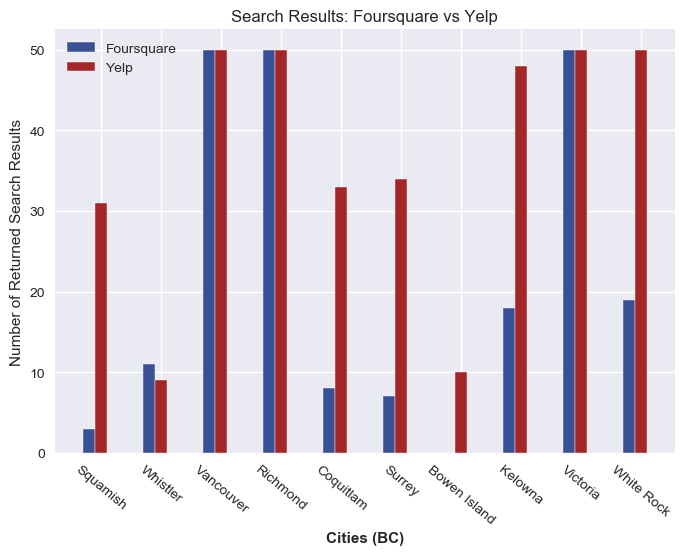

In [12]:
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('seaborn')

barWidth = 0.2
 
r1 = np.arange(len(cities))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 

plt.bar(r1, foursquare_results, color='#395097', width=barWidth, edgecolor='white', label='Foursquare')
plt.bar(r2, yelp_results, color='#A42626', width=barWidth, edgecolor='white', label='Yelp')
 

plt.title('Search Results: Foursquare vs Yelp')
    

plt.xlabel('Cities (BC)', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(cities))], cities, rotation=-40)

plt.ylabel('Number of Returned Search Results')

plt.legend()
plt.show()


# Bar graph of the number of returned results grouped by city

#### We see that Yelp generally returns more results than Foursquare for the 10 cities

#### Comparing 10 cities isnt fair or accurate way to determine best API coverage

## Is this trend consistent across 100+ random cities?

##### 147 random canadian cities

In [2]:
lines = open('canada_cities.txt').read().splitlines()
lines = [(city +', Canada').replace('\t', '') for city in lines]
# lines

In [25]:
# We are going to do the same as above, get the length of the results 
# FOR EACH city and append them to the corresponding api list where we fetched them from

yelp_hundred = []
foursquare_hunred = []

# Fetching results for each city, 147 in total
for city in lines:
    # Get results for yelp
    yelp = get_restaurant_results(city, api='yelp')
    yelp_hundred.append(len(yelp))
    
    time.sleep(1)
    
    # Get results for foursquare
    foursquare = get_restaurant_results(city, api='foursquare')
    foursquare_hunred.append(len(foursquare))

#### Get differences between yelp results and foursquare results

In [53]:
# Here we are finding the differnce between the two lists.
# number of yelp results - number of foursquare results
# Sequential operation across each 147 items between the two lists

yelp_foursquare_difference = np.array(yelp_hundred) - np.array(foursquare_hunred)
yelp_foursquare_difference

array([ 47,  43,  -3,  20,  -3,  31,  37,  40,   5,  42,  34,   7,  49,
        24,   0,   1,  29,   0,  13,  10,   1,  33,  -3,  -1,   3,  25,
         5,  23,  41,  45,  41,   5,  17, -14,   9,   0,  20,   3,  -3,
         0,   3,  21,   2,  32,  26,  40,  12,  38,  -7,   2,  40,   0,
         6,  14,   4, -17,   0,  30,  -7,  12,   1,  39,  10,  36,  18,
        41,  26,   2,  13,  37,  33,  18,  17,   5,  20,  25,   3,  11,
        -1,  47,  27,   3,   0,  17,  22,  44,  39,   0,  16,  22,  12,
        39,  40,  50,  -5,  30,  -4,  17,  29,   9,  20,   0,  25,  26,
        -1,   0,  29,  24,   0,   6,  45,  22,  36,  34,  -5,  15,  39,
        31,  24,  18,  10,  47,  27,  31,   3,  18,   8,  -1,  27,   8,
        10,  12,   0,  48,  34,   0,  19,  38,  16,  20,  31,  -4,  32,
         5,   0,  42,  -4])

In [28]:
# Saving the file so I dont have to run the for loop api above...
with open('yelp_foursquare_difference.txt', 'w') as f:
    for item in yelp_foursquare_difference:
        f.write("%s\n" % item)

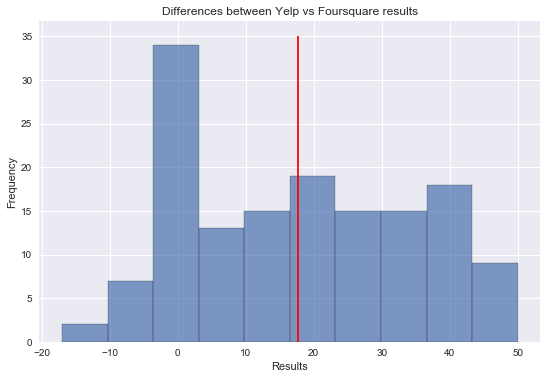

In [8]:
plt.style.use('seaborn')

plt.hist(yelp_foursquare_difference, alpha=0.7, histtype='bar', ec='black')

plt.title('Differences between Yelp vs Foursquare results')

plt.xlabel('Results')
plt.ylabel('Frequency')

plt.vlines(np.array(yelp_foursquare_difference).mean(), ymin=0, ymax=35, colors='r', linestyles='solid', label='')

plt.show()

In [20]:
# Created a histogram: The majority of the distrabution lie in the positive field (above 0)
# This means that there were more results returned for Yelp then foursquare
# The negative area represent the distribution for where more results returned for Foursquare then Yelp
# The mode is 0, which is the most frequently occuring value (both Yelp and foursquare returned the same results)

print('Mean: ', round(np.array(yelp_foursquare_difference).mean(), 1))
print('Standard Deviation: ',round(np.array(yelp_foursquare_difference).std(), 1))
print('Mode: ', stats.mode(np.array(yelp_foursquare_difference), axis=None)[0][0])

Mean:  17.7
Standard Deviation:  16.4
Mode:  0


##### Yelp produces better results then Foursquare, on average 17.7 plus difference

## Which cities in the lower mainland have on average the best restaurants?

#### Lets use Yelp, since it generally produces better results

In [6]:
# Going to compare Coquiltam, Vancouver, Richmond and Surrey.
# Get the average mean of ratings grouped by city

coquitlam_data = get_restaurant_results(cityname='Coquitlam BC', api='yelp')
vancouver_data = get_restaurant_results(cityname='Vancouver, BC', api='yelp')
richmond_data = get_restaurant_results(cityname='Richmond, BC', api='yelp')
surrey_data = get_restaurant_results(cityname='Surrey, BC', api='yelp')

In [7]:
len(coquitlam_data),len(vancouver_data),len(richmond_data),len(surrey_data),

(33, 50, 50, 34)

In [84]:
# Here we are going to pull out information i.e name, location, rating etc.. and return a list of dictionaries.
# One dictionary for each restaraunt, cleaner format. This will be used before we input the data into a Pandas DataFrame

def process_data(data):
    ls = []
    
    for r in data:
        some_dict = {}
        
        # If no 'rating' key, do not add this dictionary.
        if 'rating' not in r:
            continue
        else:
            some_dict['rating'] = r['rating']
        
        # If no coordinates skip
        if 'coordinates' not in r:
            continue
        else:
            some_dict['lat'] = r['coordinates']['latitude']
            some_dict['lon'] = r['coordinates']['longitude']
            
        
        # Check to see if theres a city
        if 'location' in r and 'city' in r['location']:
            some_dict['city'] = r['location']['city']
        else:
            some_dict['city'] = 'U'
        
        
        
        # If not name just default to 'U'
        if 'name' in r:
            some_dict['name'] = r['name']
        else:
            some_dict['name'] = 'U'
        
        
        important_categories = ['U', 
                        'American (New)', 
                        'Mexican', 
                        'Pizza', 
                        'American (Traditional)', 
                        'Burgers', 'Sandwiches', 
                        'Seafood', 
                        'Fast Food', 
                        'Bars', 
                        'Breakfast & Brunch', 
                        'Chinese', 
                        'Italian', 
                        'Mediterranean', 
                        'Coffee & Tea', 
                        'Food Trucks', 
                        'Barbeque', 
                        'Japanese', 
                        'Sushi Bars', 
                        'Korean']
        
        
        # If no category default 'U'
        if 'categories' in r and len(r['categories']) > 1:
            if r['categories'][0]['title'] in important_categories:
                some_dict['category'] = r['categories'][0]['title']
            else:
                some_dict['category'] = 'Other'
        else:
            some_dict['category'] = 'U'
        
        # If no price just default '$$'
        if 'price' in r:
            some_dict['price'] = r['price']
        else:
            some_dict['price'] = '$$'
            
        # If not price just default 0
        if 'review_count' in r:
            some_dict['review_count'] = r['review_count']
        else:
            some_dict['review_count'] = 0  
        
        ls.append(some_dict)   
    
    return ls

In [85]:
vancouver_lst = process_data(vancouver_data)
richmond_lst = process_data(richmond_data)
surrey_lst = process_data(surrey_data)
coquitlam_lst = process_data(coquitlam_data)

In [86]:
len(vancouver_lst), len(richmond_lst), len(surrey_lst), len(coquitlam_lst)

(50, 50, 34, 33)

In [87]:
# Function to input the data we processed above and output a nice Pandas DataFrame
def create_df(lst_of_data):
    x = ['name', 'rating', 'category', 'price', 'review_count', 'lat', 'lon', 'city']
    
    some_dict = {'name': [], 'category': [], 'price': [], 'review_count': [], 'lat':[], 'lon': [], 'rating': [], 'city': []}
    
    for r in lst_of_data:
        for key in x:
            some_dict[key].append(r[key])
            
    return pd.DataFrame(some_dict, columns = x)

In [88]:
vancouver_df = create_df(vancouver_lst)
coquitlam_df = create_df(coquitlam_lst)
richmond_df = create_df(richmond_lst)
surrey_df = create_df(surrey_lst)

#### After all that processing we get a Pandas DataFrame for each city

In [89]:
vancouver_df.head()

,name,rating,category,price,review_count,lat,lon,city
0,Jam Cafe on Beatty,4.5,U,$$,1067,49.280259,-123.109638,Vancouver
1,Medina Cafe,4.0,Breakfast & Brunch,$$,2282,49.280443,-123.117036,Vancouver
2,The Flying Pig - Yaletown,4.0,Other,$$,1095,49.275010,-123.122000,Vancouver
3,OEB Breakfast Co.,4.0,U,$$,331,49.273434,-123.119272,Vancouver
4,Saku,4.0,U,$$,115,49.263125,-123.116603,Vancouver


In [90]:
coquitlam_df.head()

,name,rating,category,price,review_count,lat,lon,city
0,Omega Cafe,4.5,Other,$$,41,49.276415,-122.846803,Port Moody
1,Chuncheon Dakgalbi,4.0,Barbeque,$$,9,49.276484,-122.843514,Port Moody
2,Doppio Zero Pizza,3.5,Italian,$$,32,49.263555,-122.847654,Coquitlam
3,Zhous Chinese Restaurant,3.5,U,$,12,49.262649,-122.839038,Coquitlam
4,Sun Star Chinese,3.0,U,$$,45,49.248981,-122.835332,Coquitlam


In [91]:
richmond_df.head()

,name,rating,category,price,review_count,lat,lon,city
0,Mr Bro Korean Bistro & Izakaya,4.5,U,$$,53,49.178175,-123.127902,Richmond
1,John 3:16 Malaysian Delights,4.0,U,$$,146,49.164132,-123.136219,Richmond
2,The Fish Man,4.5,Seafood,$$,34,49.178466,-123.130252,Richmond
3,Shanghai River,4.0,Chinese,$$,676,49.170740,-123.138480,Richmond
4,Micha,4.0,Chinese,$$,8,49.178684,-123.124815,Richmond


In [92]:
surrey_df.head()

,name,rating,category,price,review_count,lat,lon,city
0,Be 'wiched Cafe,4.5,U,$,46,49.104194,-122.799742,Surrey
1,New York New York,4.0,U,$$,89,49.118470,-122.801390,Surrey
2,Quesada Burritos & Tacos,4.0,U,$$,1,49.102888,-122.797281,Surrey
3,Dawood's Pizza,5.0,U,$$,2,49.118930,-122.817100,Surrey
4,West Village Cafe,4.0,Sandwiches,$$,29,49.104752,-122.799629,Surrey


In [97]:
# Appending the all the dataframes together
full_df = pd.concat([vancouver_df, coquitlam_df, richmond_df, surrey_df], axis=0) 

In [98]:
# Here we display the top cities in descending order with on average the best rated restaruants

full_df.groupby(by='city')['rating'].mean().sort_values(ascending=False)

city
Vancouver     4.180000
Richmond      4.070000
Port Moody    3.481481
Coquitlam     3.416667
Surrey        3.294118
Name: rating, dtype: float64

In [99]:
# Saving lowermainland dataframe
full_df.to_csv('canada_df.csv', index=False)

In [2]:
bc_df = pd.read_csv('canada_df.csv')

### Creating a SQL database to store BC results

In [ ]:
with sqlite.connect('restaurants.db') as con:
    cur = con.cursor()
    cur.execute("CREATE TABLE IF NOT EXISTS bc(id INTEGER PRIMARY KEY, name TEXT, rating INT, category TEXT, price TEXT, lat INT, lon INT, city INT)")
    
    for index, row in bc_df.iterrows():
        cur.execute(f"INSERT INTO bc VALUES(NULL, {row['name']}, {row['rating']}, {row['category']}, {row['price']}, {row['lat']}, {row['lon']}, {row['city']})")

### Lets find the top 10 restaurants in the lower mainland

In [52]:
# Lets get list of top 10 ascending review counts
idxs = bc_df['review_count'].sort_values(ascending=False)[:10].index
idxs

Int64Index([1, 7, 2, 0, 6, 86, 22, 18, 20, 93], dtype='int64')

In [92]:
# Sorted rating then review_count

print('TOP 10 RESTAURANTS IN THE LOWER MAINLAND')
bc_df.loc[idxs, ['name', 'rating', 'review_count', 'city']].sort_values(by=['rating', 'review_count'], ascending=[False, False]).reset_index(drop=True)

# Top 10 restaurants when including all 4 cities dataframes
# Takes into account the number of reviews a particular restaruant gotten

TOP 10 RESTAURANTS IN THE LOWER MAINLAND


,name,rating,review_count,city
0,Jam Cafe on Beatty,4.5,1067,Vancouver
1,Blue Water Cafe,4.5,902,Vancouver
2,Fanny Bay Oyster Bar & Shellfish Market,4.5,562,Vancouver
3,Medina Cafe,4.0,2282,Vancouver
4,Chambar,4.0,1349,Vancouver
5,The Flying Pig - Yaletown,4.0,1095,Vancouver
6,Shanghai River,4.0,676,Richmond
7,La Taqueria Pinche Taco Shop,4.0,609,Vancouver
8,Kirin Seafood Restaurant,4.0,485,Richmond
9,Peaceful Restaurant,3.5,569,Vancouver


## Lets create and appened a list of 100 top populated US cities and see the top 5 average reviews of restaurants by city

In [100]:
cities_df = pd.read_csv('C:/Users/Jesse/downloads/uscities.csv')
cities_df['location'] = cities_df['city']+ ', ' + cities_df['state']
list_of_cities = cities_df['location'].values
list_of_cities

array(['New York, New York', 'Los Angeles, California',
       'Chicago, Illinois', 'Houston, Texas',
       'Philadelphia, Pennsylvania', 'Phoenix, Arizona',
       'San Antonio, Texas', 'San Diego, California', 'Dallas, Texas',
       'San Jose, California', 'Austin, Texas', 'Indianapolis, Indiana',
       'Jacksonville, Florida', 'San Francisco, California',
       'Columbus, Ohio', 'Charlotte, North Carolina', 'Fort Worth, Texas',
       'Detroit, Michigan', 'El Paso, Texas', 'Memphis, Tennessee',
       'Seattle, Washington', 'Denver, Colorado',
       'Washington, District of Columbia', 'Boston, Massachusetts',
       'Nashville-Davidson, Tennessee', 'Baltimore, Maryland',
       'Oklahoma City, Oklahoma', 'Louisville/Jefferson County, Kentucky',
       'Portland, Oregon', 'Las Vegas, Nevada', 'Milwaukee, Wisconsin',
       'Albuquerque, New Mexico', 'Tucson, Arizona', 'Fresno, California',
       'Sacramento, California', 'Long Beach, California',
       'Kansas City, Missouri',

In [102]:
for city in list_of_cities:
    data = get_restaurant_results(cityname=city)
    lst_of_resturants_per_city = process_data(data)
    df = create_df(lst_of_resturants_per_city)
    full_df = pd.concat([full_df, df], axis=0)


full_df.shape


# So we fetch, process and put into a DataFrame all the restuarants we get from each of the 100 cities above
# Resulting DataFrame has 4647 rows, 8 columns

(4647, 8)

In [103]:
# SAVE CSV FILE
full_df.to_csv(r'./full_df.csv', index = False)

In [91]:
full_df = pd.read_csv('./full_df.csv')
full_df.head()

,name,rating,category,price,review_count,lat,lon,city
0,Jam Cafe on Beatty,4.5,U,$$,1067,49.280259,-123.109638,Vancouver
1,Medina Cafe,4.0,Breakfast & Brunch,$$,2282,49.280443,-123.117036,Vancouver
2,The Flying Pig - Yaletown,4.0,Other,$$,1095,49.275010,-123.122000,Vancouver
3,OEB Breakfast Co.,4.0,U,$$,331,49.273434,-123.119272,Vancouver
4,Saku,4.0,U,$$,115,49.263125,-123.116603,Vancouver


In [1]:
# with sqlite.connect('restaurants.db') as con:
#     cur = con.cursor()
#     cur.execute("CREATE TABLE IF NOT EXISTS us_can(id INTEGER PRIMARY KEY, name TEXT, rating INT, category TEXT, price TEXT, lat INT, lon INT, city INT)")
    
#     for index, row in bc_df.iterrows():
#         cur.execute(f"INSERT INTO bc VALUES(NULL, {row['name']}, {row['rating']}, {row['category']}, {row['price']}, {row['lat']}, {row['lon']}, {row['city']})")

In [39]:
# Get all the cities where the sum of their review_count is the heightest
top_reviews = full_df.groupby(by='city')['review_count'].sum().sort_values(ascending=False)[:15].index

In [93]:
print('TOP 5 CITIES WITH HIGHEST AVERAGE RATINGS OF RESTAURANTS (GROUPED BY CITY)')

# review_count is taken into consideration
round(full_df.groupby(by='city')['rating'].mean().loc[top_reviews].sort_values(ascending=False)[:5],2)

# This also takes into account review_count column, I didnt include summed review_counts less then a certain number.

TOP 5 CITIES WITH HIGHEST AVERAGE RATINGS OF RESTAURANTS (GROUPED BY CITY)


city
Los Angeles    4.41
Portland       4.40
Chicago        4.32
Seattle        4.28
Nashville      4.26
Name: rating, dtype: float64

# Machine Learning

### Can we make a model that predicts the sentiment/rating of a resturant given the following feature paramters (lat, lon, review_count, pricing and category)?

In [104]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

In [105]:
full_df = pd.read_csv('full_df.csv')

In [106]:
full_df.shape

(4647, 8)

#### So instead of trying to predict a float value rating such as "3.5 stars", Ive decided to change the rating column to 'Good', 'Neutral'  or 'Bad'

In [107]:
def get_sentiment(x):
    if x>=4:
        return 'Good'
    elif x>=3 and x<4:
        return 'Neutral'
    elif x < 3:
        return 'Bad'

In [108]:
# Converting our rating column (Dependant variable) to either 'Good', 'Neutral', 'Bad'
full_df['rating'] = full_df['rating'].apply(lambda x: get_sentiment(x))
full_df['rating'].unique()

array(['Good', 'Neutral', 'Bad'], dtype=object)

In [109]:
# Drop useless columns
X = full_df.drop(['name', 'city', 'rating'], axis='columns')
y = full_df['rating']

X.shape, y.shape

((4647, 5), (4647,))

In [110]:
# split our data

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)

xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

((3717, 5), (3717,), (930, 5), (930,))

In [111]:
categorical_columns = ['price', 'category']
numerical_columns = ['review_count', 'lat', 'lon']

ct = ColumnTransformer([('ohe', OneHotEncoder(), categorical_columns), 
                        ('stdsclr', StandardScaler(), numerical_columns)], remainder='passthrough')

transformed_xtrain = ct.fit_transform(xtrain)

In [112]:
rf_clf = RandomForestClassifier()
ada_clf = AdaBoostClassifier()
xgb_clf = XGBClassifier()

rf_clf.fit(transformed_xtrain, ytrain)
ada_clf.fit(transformed_xtrain, ytrain)
xgb_clf.fit(transformed_xtrain, ytrain)

XGBClassifier(objective='multi:softprob')

In [113]:
transformed_xtest = ct.transform(xtest)

print('Random forest: ', round(rf_clf.score(transformed_xtest, ytest)*100, 2), '%')
print('Adaboost: ', round(ada_clf.score(transformed_xtest, ytest)*100, 2), '%')
print('XGboost: ', round(xgb_clf.score(transformed_xtest, ytest)*100, 2), '%')

# Accuracy: Our models correctly predicted the results 70% of the time

Random forest:  70.32 %
Adaboost:  70.86 %
XGboost:  72.47 %


#### Lets make a prediction!

In [54]:
# Create a function to predict random choice using Adaboost!

def get_prediction(idx):
    # Transform the sample 
    sampled_transformed = ct.transform(xtest.loc[[idx]])
    
    # Make prediction
    prediction = ada_clf.predict(sampled_transformed)[0]
    actual = ytest.loc[idx]
    
    print("Models prediction: ", prediction)
    print("Actual: ", actual)
    

In [65]:
# Get a random sample from the xtest set!
random_index = np.random.choice(xtest.index)

sample = full_df.loc[[random_index]]

sample

,name,rating,category,price,review_count,lat,lon,city
2265,Lowry Hill Meats,Good,Other,$$,61,44.96301,-93.29152,Minneapolis


In [66]:
get_prediction(random_index)

Models prediction:  Good
Actual:  Good


### What is the percentage of randomly guessing a multiclass label with 3 different possible classes correctly?

## The models are technically doing better then guessing but the question is:
## Can we trust the accuracy of these models?

### Answer: NO!

In [72]:
full_df['rating'].value_counts()

Good       3248
Neutral    1082
Bad         317
Name: rating, dtype: int64

In [60]:
# Looking at the value counts above we see that the total proportion of samples labled "Good" account for 70% of total data
# Our dataset is imbalanced.

#('Good')/('Good'+ + 'Neutral' + 'Bad') = ~0.7
#

# Therefore, if we created a function that just predicts/outputs 'Good' every time it saw a sample from our test set
# this dumb function would also acheive 70% accuracy also.

total = full_df['rating'].value_counts().sum()
proportion_of_good = round((full_df['rating'].value_counts()['Good'])/total, 1)*100



print(f'Proportion of samples classified as "Good":  {proportion_of_good}%')

# Therefore we cannot trust the accuracy metric for a model on this imbalenced data set

Proportion of samples classified as "Good":  70.0%


## F1 score is a better metric then accuracy because it takes into account precision and recall.

In [67]:
# As you increase recall you will decrease precision (i.e more false positives)
# As you increase precision you will decrease recall (i.e more false negatives)
# Need to find the right balance between the two metrics for a model

# So for the example of the function that just returns 'Good':
# That function has very high recall but very low precision (Produces lots of false positives)

# F1 score will combine both metrics to produce an overall score.

In [76]:
from sklearn.metrics import f1_score, accuracy_score

In [114]:
actual_guessing = [np.random.randint(low=0, high=3) for _ in range(10000)]
prediction_guessing = [np.random.randint(low=0, high=3) for _ in range(10000)]

print('Random guessing on 3 classes on balanced data set: ', round(f1_score(actual_guessing, prediction_guessing, average='weighted')*100,2), '%')

Random guessing on 3 classes on balanced data set:  33.66 %


In [117]:
# The f1 score on our imbalanced dataset if we just output 'Good' for every prediction

preds = ['Good' for _ in range(full_df.shape[0])]
print('f1 score on just predicting "Good" for every sample for our test data:',round(f1_score(y, preds, average='weighted')*100, 2), '%')

f1 score on just predicting "Good" for every sample for our test data: 57.51 %


###### F1 score is lower then accuracy score because it is being penalized for the low precision i.e predicting 'Good' for every sample

In [116]:
y_preds = ada_clf.predict(transformed_xtest)
print('f1 score for our models predictions on the test data: ',round(f1_score(ytest, y_preds, average='weighted')*100, 2), '%')

f1 score for our models predictions on the test data:  65.68 %


### Conclusion: Our model statistically preforms better then just random guessing, but only slightly better then one that outputs a constant label.

### Therefore the answer is no, we cannot make a decent model with the given feature variables (lat, lon, category, price, review_count) to predict sentiment/rating of a restaurant.

## FIN